In [ ]:
import wbgapi as wb
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [2]:
# wb.source.info()

In [3]:
# wb.series.info(db = 2)

In [4]:
paises = ["AFG","SLE","NGA", "IND", "CHN", "IDN", "KEN", "BRA", "MEX","COL" ,"USA", "JPN", "KOR" , "SGP", "DEU", "FRA", "GBR", "NLD", "DNK"]

In [5]:
wdi_indicators = [
    "NY.GDP.MKTP.PP.KD",      # PIB PPA constante internacional
    "SP.URB.TOTL.IN.ZS",       # % de población urbana
    "GE.EST",                 # Estimate of Government Effectiveness
    "RQ.EST"                  # Estimate of Regulatory Quality
]




In [6]:
# Descargar datos de WDI (db=2)
df_wdi = wb.data.DataFrame(
    wdi_indicators,
    economy=paises,
    time=range(2020, 2023),
    labels=True,
    db=2
)

In [7]:
df= df_wdi.reset_index()[["Country", "Series", "YR2020", "YR2021", "YR2022"]]

In [8]:

df_long = pd.melt(
    df,
    id_vars=["Country", "Series"],         # columnas que no se derriten
    value_vars=["YR2020", "YR2021", "YR2022"],  # columnas a convertir en filas
    var_name="Year",                       # nuevo nombre para la columna de años
    value_name="Value"                     # nuevo nombre para los valores
)

# Limpiar el campo 'Year' para que quede solo el número (ej: 2020 en vez de 'YR2020')
df_long["Year"] = df_long["Year"].str.replace("YR", "").astype(int)

# Renombrar columnas para más claridad (opcional)
df_long = df_long.rename(columns={
    "Country": "Country",
    "Series": "Indicator",
    "Value": "Value"
})


In [9]:
# Diccionario de traducción
traducciones_paises = {
    'Denmark': 'Dinamarca',
    'Netherlands': 'Países Bajos',
    'United Kingdom': 'Reino Unido',
    'France': 'Francia',
    'Germany': 'Alemania',
    'Singapore': 'Singapur',
    'Korea, Rep.': 'Corea del Sur',
    'Japan': 'Japón',
    'United States': 'Estados Unidos',
    'Colombia': 'Colombia',
    'Mexico': 'México',
    'Brazil': 'Brasil',
    'Kenya': 'Kenia',
    'Indonesia': 'Indonesia',
    'China': 'China',
    'India': 'India',
    'Nigeria': 'Nigeria',
    'Sierra Leone': 'Sierra Leona',
    'Afghanistan': 'Afganistán'
}

# Aplicar traducción
df_long["Country"] = df_long["Country"].replace(traducciones_paises)

traducciones_indicadores = {
    'GDP, PPP (constant 2021 international $)': 'PIB, PPA (dólares internacionales constantes de 2021)',
    'Urban population (% of total population)': 'Población urbana (% de la población total)',
    'Government Effectiveness: Estimate': 'Efectividad del gobierno: estimación',
    'Regulatory Quality: Estimate': 'Calidad regulatoria: estimación'
}

# Aplicar la traducción a la columna "Indicator"
df_long["Indicator"] = df_long["Indicator"].replace(traducciones_indicadores)

In [17]:
df_long

,Country,Indicator,Year,Value
0,Dinamarca,"PIB, PPA (dólares internacionales constantes d...",2020,3.798907e+11
1,Países Bajos,"PIB, PPA (dólares internacionales constantes d...",2020,1.130273e+12
2,Reino Unido,"PIB, PPA (dólares internacionales constantes d...",2020,3.147041e+12
3,Francia,"PIB, PPA (dólares internacionales constantes d...",2020,3.330487e+12
4,Alemania,"PIB, PPA (dólares internacionales constantes d...",2020,5.013622e+12
...,...,...,...,...
223,China,Calidad regulatoria: estimación,2022,-4.184176e-01
224,India,Calidad regulatoria: estimación,2022,-5.044642e-02
225,Nigeria,Calidad regulatoria: estimación,2022,-1.155945e+00
226,Sierra Leona,Calidad regulatoria: estimación,2022,-1.055578e+00


In [15]:
df_long.columns.to_list()

['Country', 'Indicator', 'Year', 'Value']

In [ ]:


# Pivotear sin cambiar nombres de columnas
df_pivot = df_long.pivot(index=['Country', 'Year'], columns='Indicator', values='Value').reset_index()

# Identificar las columnas originales por nombre completo
col_pib = 'PIB, PPA (dólares internacionales constantes de 2021)'
col_urb = 'Población urbana (% de la población total)'
col_gov = 'Efectividad del gobierno: estimación'
col_reg = 'Calidad regulatoria: estimación'

# Transformaciones
df_pivot[f'{col_pib}_log'] = np.log10(df_pivot[col_pib] + 1)
df_pivot[f'{col_urb}_minmax'] = df_pivot[col_urb] / 100

scaler_gov = StandardScaler()
df_pivot[f'{col_gov}_std'] = scaler_gov.fit_transform(df_pivot[[col_gov]])

scaler_reg = StandardScaler()
df_pivot[f'{col_reg}_std'] = scaler_reg.fit_transform(df_pivot[[col_reg]])


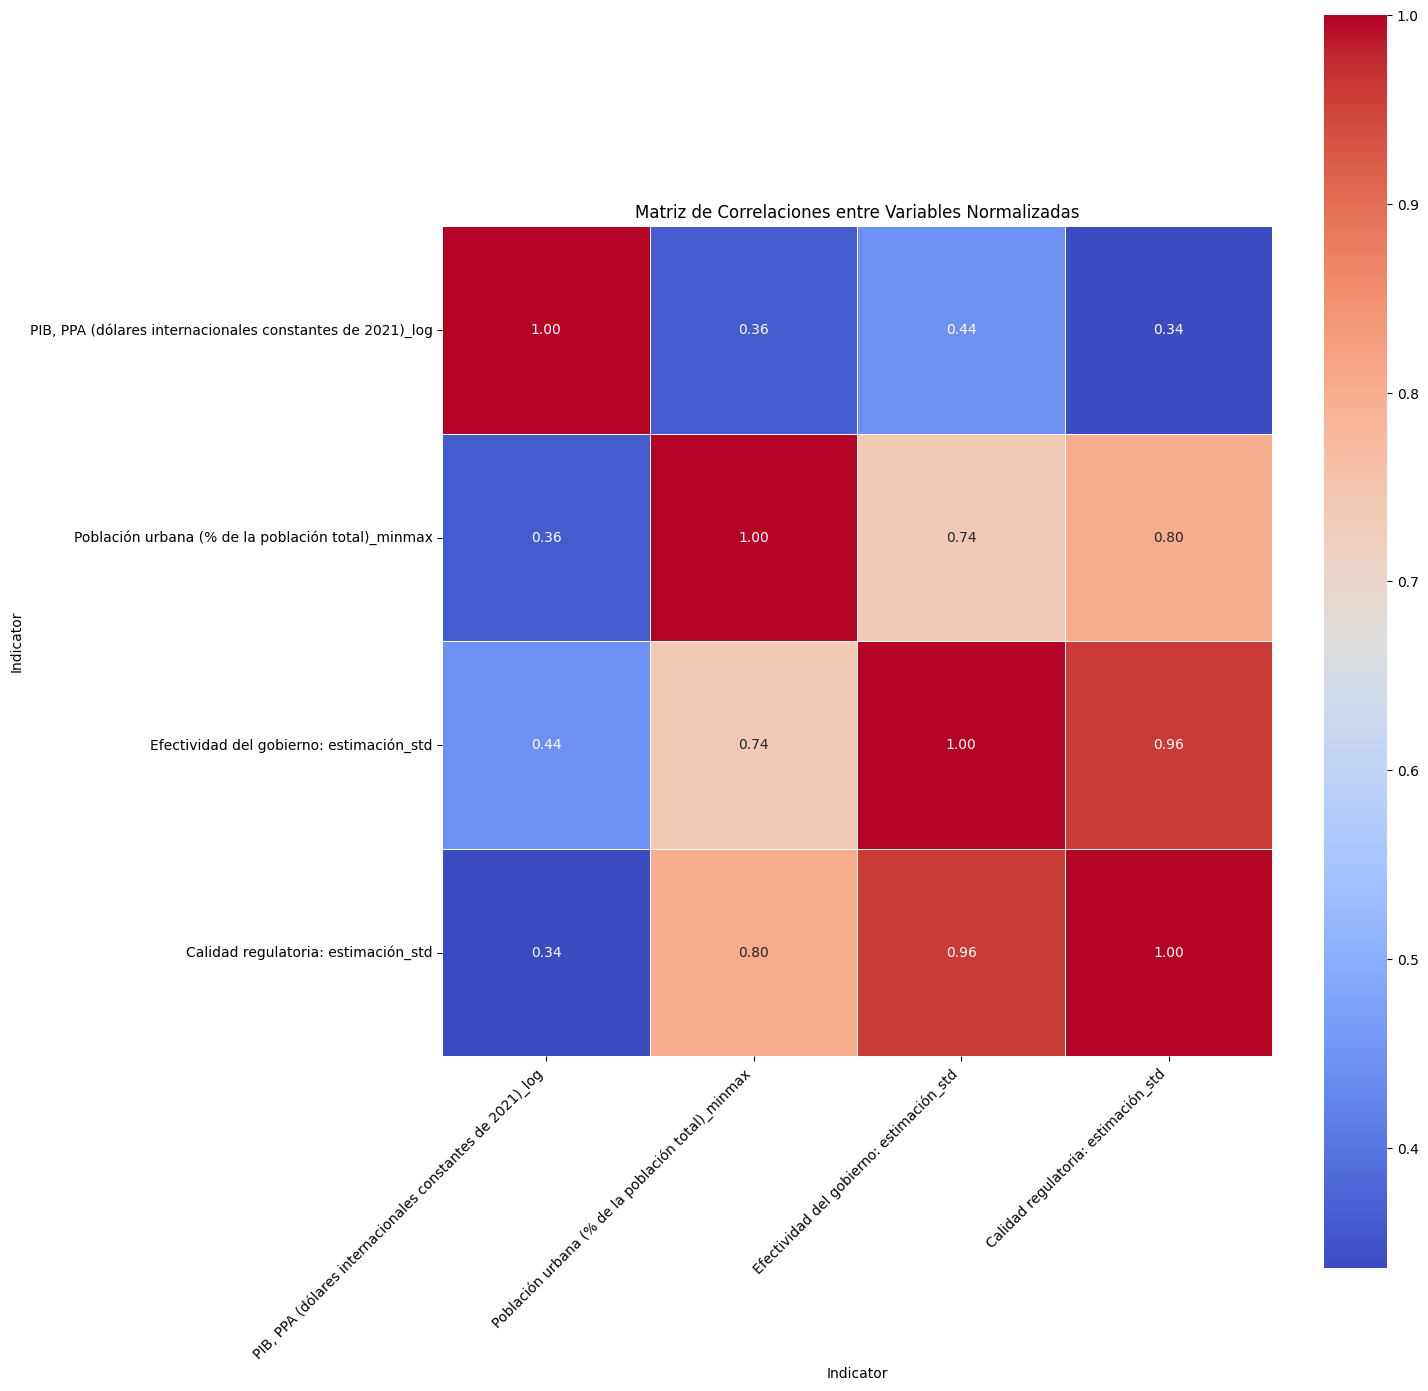

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar columnas transformadas
cols_transformadas = [col for col in df_pivot.columns if col.endswith(('_log', '_minmax', '_std'))]

# Calcular matriz de correlaciones
correlation_matrix = df_pivot[cols_transformadas].corr()

# Visualizar con seaborn
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Matriz de Correlaciones entre Variables Normalizadas")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [24]:
df_pivot.to_csv("df_pivot.csv", index=False)